### Carga de datos

In [1]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('default')
sns.set()

In [3]:
#Funciones auxiliares
def mostrar_porcentaje_barplot(ax):
    suma = 0
    for p in ax.patches:
        suma += p.get_height()
    for p in ax.patches:
        ax.annotate(str(np.round(100 *(p.get_height() / suma),decimals=2)) + "%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
def mostrar_valores_barplot(ax):
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [4]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})

## Los usuarios que hicieron checkout. ¿Concretaron la conversión?

In [5]:
checkouts = df.loc[df['event'] == 'checkout',["sku","timestamp","person","model","condition","storage","color"]]
conversiones = df.loc[df['event'] == 'conversion',["sku","timestamp","person","model","condition","storage","color"]]

### Observemos la evolución de los checkouts en el tiempo

Text(0.5,1,'Checkouts semanales')

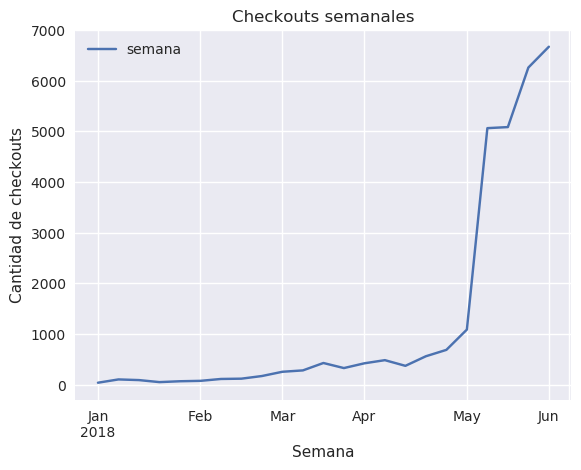

In [6]:
checkouts_by_week = checkouts.loc[:, ['timestamp']]
checkouts_by_week['semana'] = checkouts_by_week['timestamp'].dt.week - 1
checkouts_by_week = checkouts_by_week[checkouts_by_week['semana'] != checkouts_by_week['semana'].max()] #Borro la ultima semana incompleta
checkouts_by_week['semana'] = pd.to_datetime('2018', format='%Y') + pd.to_timedelta(checkouts_by_week['semana'].mul(7).astype('str') + ' days')

checkouts_weeks = checkouts_by_week['semana'].value_counts().to_frame().sort_index()
ax = checkouts_weeks.plot()
ax.set(xlabel='Semana', ylabel='Cantidad de checkouts')
ax.set_title('Checkouts semanales')

Aparentemente, algo ocurrió a mitad de Mayo. Haciendo zoom podemos ver que el 14 comenzaron a aumentar los checkouts.

Text(0.5,1,'Checkouts 11/05 al 17/05')

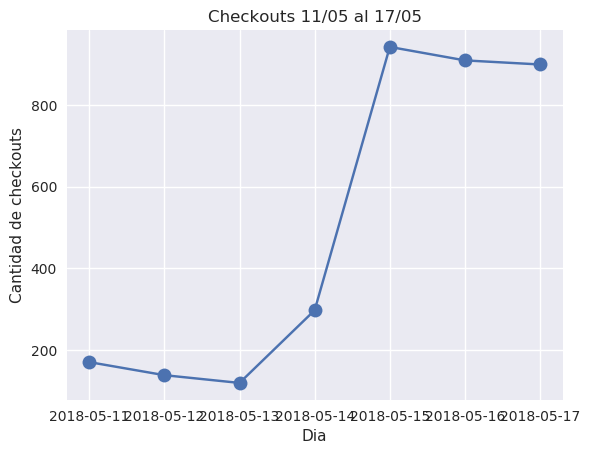

In [7]:
acotado = checkouts.loc[(checkouts['timestamp'] > pd.to_datetime("2018-05-11")) & (checkouts['timestamp'] < pd.to_datetime("2018-05-18"))].copy()
acotado['fecha'] = acotado['timestamp'].dt.date

ax = acotado['fecha'].value_counts().plot(marker=".",markersize="20")
ax.set(xlabel='Dia', ylabel='Cantidad de checkouts')
ax.set_title('Checkouts 11/05 al 17/05')

Ahora analicemos la evolución de las conversiones.

Text(0.5,1,'Conversiones semanales')

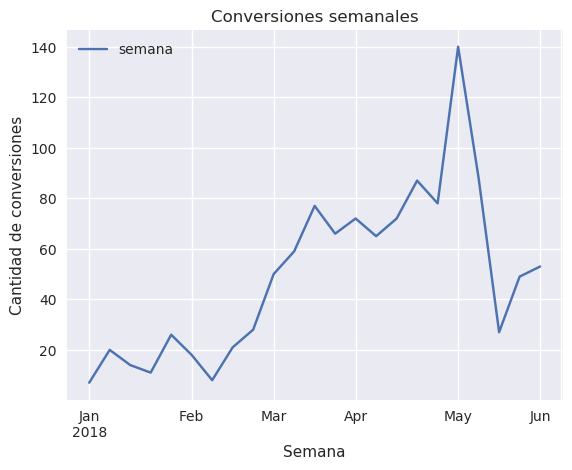

In [8]:
conversiones_by_week = conversiones.loc[:, ["timestamp"]]
conversiones_by_week['semana'] = conversiones_by_week['timestamp'].dt.week - 1
conversiones_by_week = conversiones_by_week[conversiones_by_week['semana'] != conversiones_by_week['semana'].max()] #Borro la ultima semana incompleta
conversiones_by_week['semana'] = pd.to_datetime('2018', format='%Y') + pd.to_timedelta(conversiones_by_week['semana'].mul(7).astype('str') + ' days')

conversiones_weeks = conversiones_by_week['semana'].value_counts().to_frame().sort_index()
ax = conversiones_weeks.plot()
ax.set(xlabel='Semana', ylabel='Cantidad de conversiones')
ax.set_title('Conversiones semanales')

Veamos si hay correlación entre el aumento de checkouts y las conversiones.

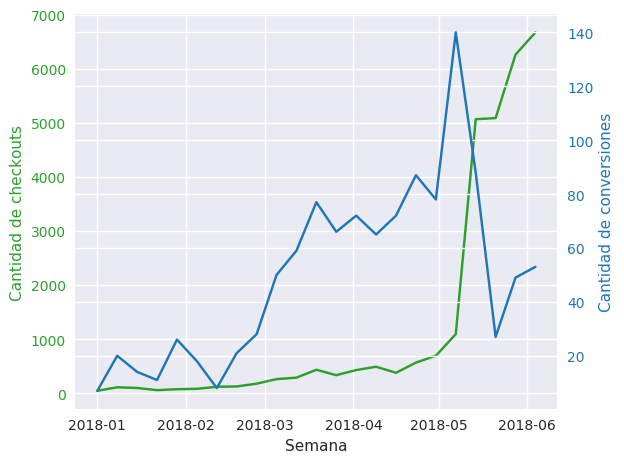

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Semana')
ax1.set_ylabel('Cantidad de checkouts', color=color)
ax1.plot(checkouts_weeks['semana'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Cantidad de conversiones', color=color)
ax2.plot(conversiones_weeks['semana'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


Se observa un aumento significativo tanto de conversiones como de checkouts en la segunda semana de mayo, pero de ahi en adelante solo los checkouts siguieron aumentando mientras que las conversiones disminuyeron. Analizaremos la proporcion de conversiones sobre checkouts hasta esa semana.

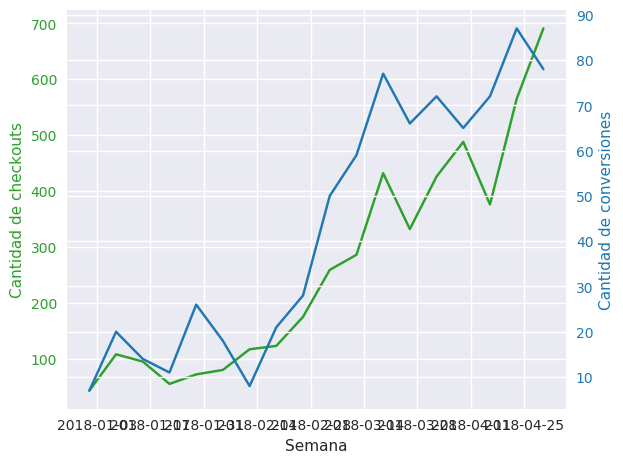

In [10]:
checkouts_hasta_mayo = checkouts_weeks.iloc[0:18]
conversiones_hasta_mayo = conversiones_weeks.iloc[0:18]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Semana')
ax1.set_ylabel('Cantidad de checkouts', color=color)
ax1.plot(checkouts_hasta_mayo, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Cantidad de conversiones', color=color)
ax2.plot(conversiones_hasta_mayo, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

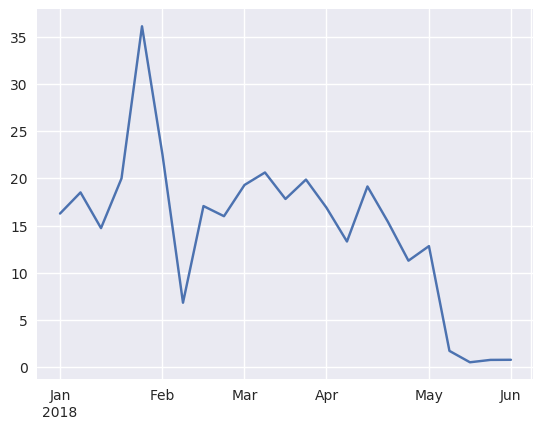

In [11]:
porcentaje_conversiones_sobre_checkouts = (conversiones_weeks['semana'] / checkouts_weeks['semana']) * 100
ax = porcentaje_conversiones_sobre_checkouts.plot()

Vemos que hasta mayo la cantidad de checkouts y conversiones estaban intimamente relacionadas, representando alrededor de un 15% la cantidad de conversiones sobre la cantidad de checkouts. Debemos analizar que sucede en mayo que hace que de ahi en adelante suban los checkouts pero bajen las conversiones.

### Marcas con mas checkouts y conversiones

In [12]:
def obtener_marca(serie_de_modelo):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(modelo.split()[0])
    return r

Text(0,0.5,'Cantidad')

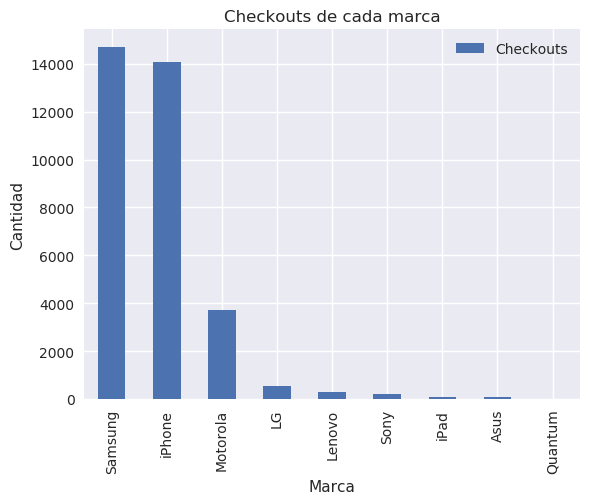

In [13]:
checkouts["Marca"] = obtener_marca(checkouts["model"])
checkouts = checkouts.loc[checkouts["Marca"] != "Unknown"] # Remuevo datos erroneos
checkouts["Checkouts"] = 1
checkouts_by_marca = checkouts[["Marca","Checkouts"]].groupby(by=["Marca"]).agg("count")\
    .sort_values(by="Checkouts",ascending=False)
checkouts_by_marca.plot(kind="bar",title="Checkouts de cada marca").set_ylabel("Cantidad")

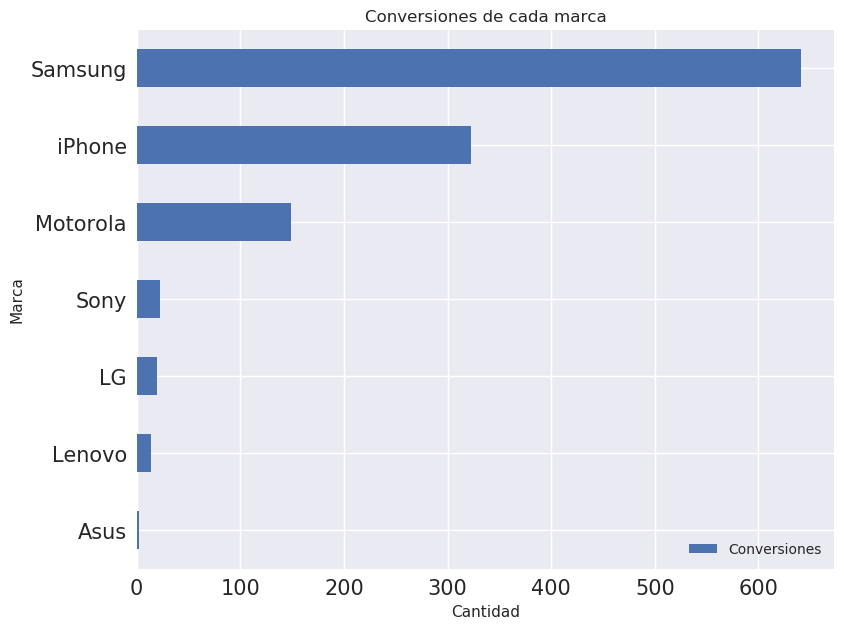

In [14]:
conversiones["Marca"] = obtener_marca(conversiones["model"])
conversiones = conversiones.loc[conversiones["Marca"] != "Unknown"] # Remuevo datos erroneos
conversiones["Conversiones"] = 1
conversiones_by_marca = conversiones[["Marca","Conversiones"]].groupby(by=["Marca"]).agg("count")\
    .sort_values(by="Conversiones",ascending=False).iloc[::-1]
p = conversiones_by_marca.plot(kind="barh",figsize=(9,7),fontsize=15,title="Conversiones de cada marca")
p.set_xlabel("Cantidad")
p.legend(loc="lower right")
p

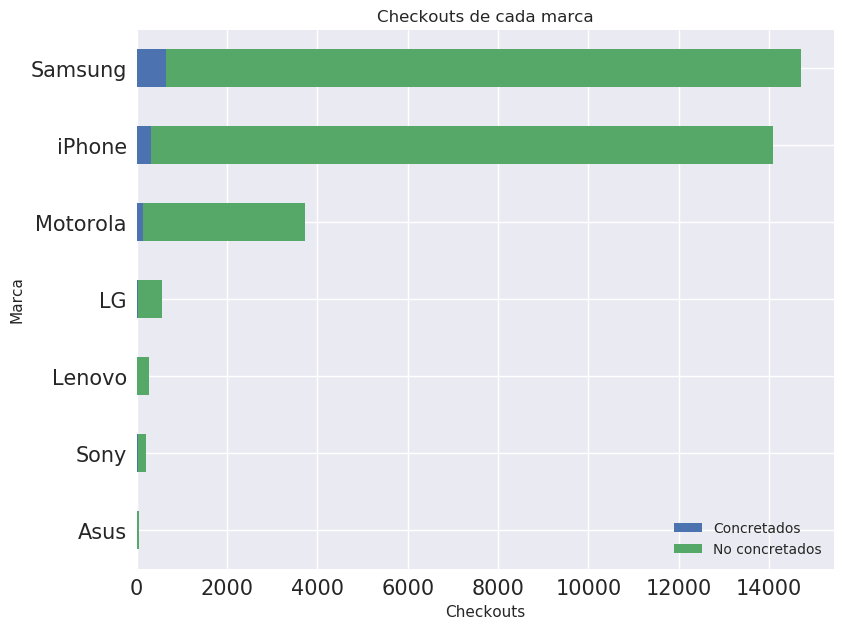

In [15]:
marca_stats = conversiones_by_marca.join(checkouts_by_marca).sort_values(by="Checkouts",ascending=False)
marca_stats["No concretados"] = marca_stats["Checkouts"] - marca_stats["Conversiones"]
marca_stats = marca_stats.rename(columns={'Conversiones': 'Concretados'}).iloc[::-1]
marca_stats.drop("Checkouts", axis=1, inplace= True)
p = marca_stats.plot(kind="barh",stacked=True,figsize=(9,7),fontsize=15,\
                 title="Checkouts de cada marca")
p.legend(loc="lower right")
p.set_xlabel("Checkouts")
p

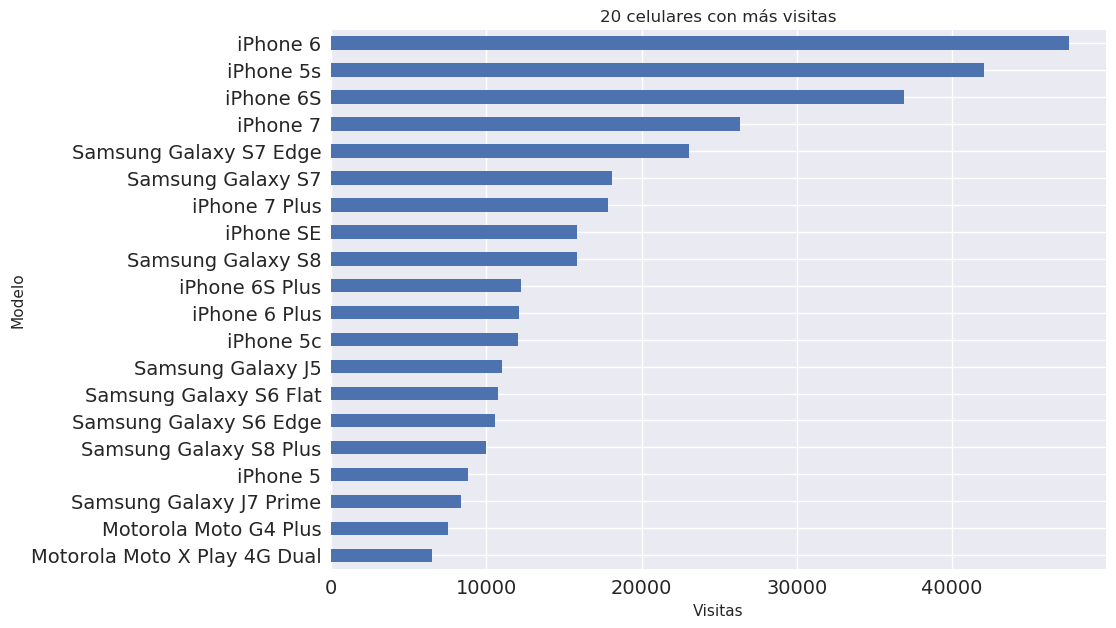

In [16]:
view_products = df.loc[df["event"] == "viewed product",["model"]].copy()
view_products["Marca"] = obtener_marca(view_products["model"])
view_products["Visitas"] = 1
p = view_products.groupby(by=["model"]).agg("sum").sort_values(by="Visitas",ascending=False).head(20)\
    .iloc[::-1].plot(kind="barh",title="20 celulares con más visitas",figsize=(10,7),fontsize=14,legend=False)
p.set_ylabel("Modelo")
p.set_xlabel("Visitas")
p

In [17]:
view_products

,model,Marca,Visitas
2,iPhone 5s,iPhone,1
4,Samsung Galaxy S8,Samsung,1
13,Motorola Moto Z Play,Motorola,1
22,iPhone 7 Plus,iPhone,1
26,iPhone 6S,iPhone,1
27,iPhone 6S,iPhone,1
28,iPhone 6S,iPhone,1
29,iPhone 6S,iPhone,1
30,iPhone 6S,iPhone,1
31,iPhone 6S,iPhone,1


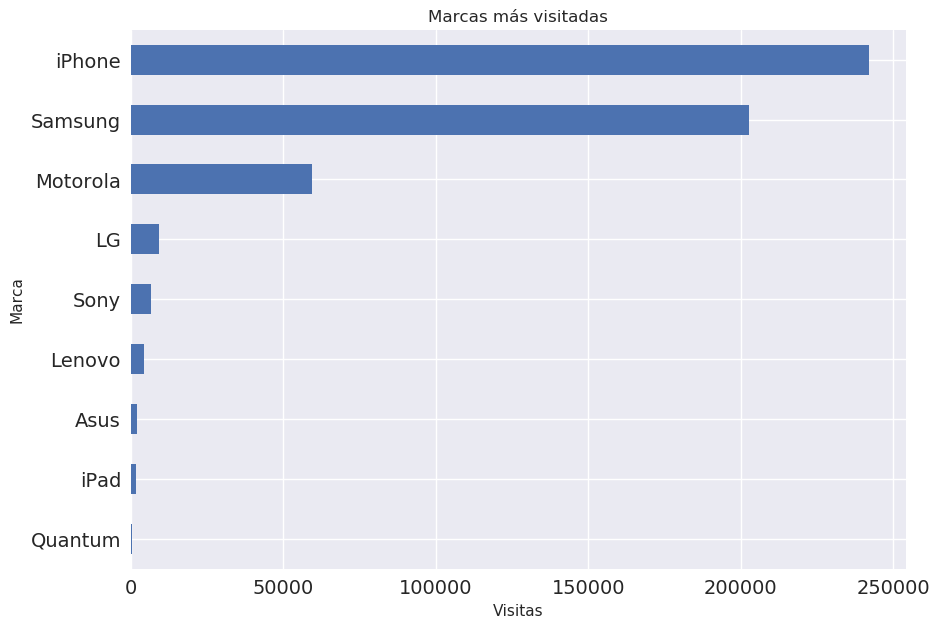

In [18]:
view_products_by_marca = view_products.drop(columns=["model"]).groupby(by="Marca").agg("sum")

p = view_products_by_marca.sort_values(by="Visitas",ascending=False)\
    .iloc[::-1].plot(kind="barh",title="Marcas más visitadas",figsize=(10,7),fontsize=14,legend=False)
p.set_xlabel("Visitas")
p


In [19]:
marca_stats = view_products_by_marca.join(checkouts_by_marca,on="Marca",how="outer")\
    .join(conversiones_by_marca,on="Marca",how="outer")
marca_stats['Visitas']= (marca_stats['Visitas']/marca_stats['Visitas'].sum()) *100
marca_stats['Checkouts']= (marca_stats['Checkouts']/marca_stats['Checkouts'].sum()) *100
marca_stats['Conversiones']= (marca_stats['Conversiones']/marca_stats['Conversiones'].sum()) * 100
marca_stats = marca_stats.fillna(0)
marca_stats = marca_stats.T

In [20]:
#import plotly.plotly as py
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go

data = [go.Scatterpolar(
  r = marca_stats["Samsung"].tolist(),
  theta = ['Visitas','Checkouts','Conversiones'],
    name = 'Samsung',
  fill = 'toself'
),go.Scatterpolar(
  r = marca_stats["iPhone"].tolist(),
  theta = ['Visitas','Checkouts','Conversiones'],
    name = 'iPhone',
  fill = 'toself'
),go.Scatterpolar(
  r = marca_stats["Motorola"].tolist(),
  theta = ['Visitas','Checkouts','Conversiones'],
    name = 'Motorola',
    fill = 'toself'
)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 60]
    )
  ),
    title='Porcentaje de visitas, checkouts, y conversiones de marcas',
    font= dict(
        size =18
    ),
  showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

ModuleNotFoundError: No module named 'plotly'

In [ ]:
view_products = df.loc[(df["event"] == "viewed product")|(df["event"] == "checkout")|(df["event"] == "conversion"),["model",'event']].copy()
view_products["Marca"] = obtener_marca(view_products["model"])
view_products["Visitas"] = view_products['event']=='viewed product'
view_products['checkouts']= view_products['event']=='checkout'
view_products['compras']= view_products['event']=='conversion'    
view_products_by_model= view_products.groupby(by=["model"]).agg({'Visitas':'sum','checkouts':'sum','compras':'sum'}).sort_values(by="Visitas",ascending=False).head(20)


fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=True)


ax.yaxis.tick_left()

view_products_by_model['Visitas'].iloc[::-1].plot(kind="barh",title="20 celulares con más visitas",figsize=(10,7),fontsize=10,legend=False,ax=ax)
view_products_by_model['checkouts'].iloc[::-1].plot(kind="barh",title="checkouts",figsize=(10,7),fontsize=10,legend=False,ax=ax2)
view_products_by_model['compras'].iloc[::-1].plot(kind="barh",title="compras",figsize=(10,7),fontsize=10,legend=False,ax=ax3)

plt.show()

#### Analsis de checkouts por persona

Veo si existen casos de double tracking

In [ ]:
def min_diferencia_tiempo(df):
        min_diferencia=pd.to_timedelta('365 days')
        for i in range(1,len(df)):
            dif = df.iloc[i]-df.iloc[i-1]
            if dif<min_diferencia:
                min_diferencia = dif
        return min_diferencia    
            
checkouts_por_persona = df.loc[df['event']=='checkout',['timestamp','person','model', 'sku']]
duplicados = checkouts_por_persona[checkouts_por_persona.duplicated(subset=['person'], keep=False)]
min_diferencia_checkouts = duplicados.groupby('person').agg({'timestamp':min_diferencia_tiempo}).sort_values(by='timestamp')
min_diferencia_checkouts['menos_de_1seg'] = min_diferencia_checkouts['timestamp']<pd.to_timedelta('00:00:01')
min_diferencia_checkouts['menos_de_1seg'].value_counts()

Existe solo 1 caso de todos los checkouts que podría ser de double tracking, lo examino

In [ ]:
min_diferencia_checkouts.loc[min_diferencia_checkouts['menos_de_1seg']==True]

In [ ]:
checkouts_por_persona.loc[checkouts_por_persona['person']=='0ee73fbe']

Los dos eventos de checkout que son en el mismo momento son de modelos distintos, por lo tanto supondremos que no es un caso de double tracking

### Analizo la cantidad de checkouts por persona 

In [ ]:
checkouts_por_persona['checkouts'] = 1
checkouts_por_persona["marca"] = obtener_marca(checkouts_por_persona["model"])
for marca in ['Samsung','iPhone','Motorola','LG','Lenovo','Sony','Quantum','iPad','Asus']:
    checkouts_por_persona[marca] = checkouts_por_persona['marca'] == marca
checkouts_por_persona.head()    
    

In [ ]:

cantidad_de_checkouts_por_persona = checkouts_por_persona.groupby('person').agg({'checkouts':sum,\
        'Samsung':sum,'iPhone':sum,'Motorola':sum,'LG':sum,'Lenovo':sum,'Sony':sum,\
        'Quantum':sum,'iPad':sum,'Asus':sum})
g = cantidad_de_checkouts_por_persona['checkouts'].value_counts().plot('bar')
g.set_title('Cantidad de checkouts por persona')
g.set_xlabel('Cantidad de checkouts')
g.set_ylabel('Numero de personas')

In [ ]:
cant_checkouts_log=cantidad_de_checkouts_por_persona['checkouts'].value_counts()#.transform(lambda x: np.log(x)+1 )
g_log = cant_checkouts_log.plot('bar')
g_log.set_yscale('log')
g_log.yaxis.set_major_formatter(ScalarFormatter())
g_log.set_title('Cantidad de checkouts por persona [Log]')
g_log.set_xlabel('Cantidad de checkouts')
g_log.set_ylabel('Cantidad de personas')
mostrar_valores_barplot(g_log)

#### Verifico si los distintos checkouts son sobre los mismos modelos

In [ ]:
a = checkouts_por_persona.groupby('person').agg({'model':'nunique','checkouts':'count'})
g = a.groupby('checkouts').agg({'model':'mean'}).plot(kind='bar',alpha=0.5, legend=False)
a.loc[a['checkouts']==24]
g.set_title('Promedio de modelos dintintos por cantidad de checkouts')
g.set_xlabel('Número de checkouts')
g.set_ylabel('Número de modelos distintos vistos')

#### Hago un analisis de las marcas que mas se aparecen en funcion de la cantidad de checkouts que hizo cada cliente

In [ ]:
multiples = cantidad_de_checkouts_por_persona.loc[cantidad_de_checkouts_por_persona['checkouts']>1]

my_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#bcbd22", "#17becf"]  
g = multiples.groupby('checkouts').agg({'Samsung':sum,'iPhone':sum,'Motorola':sum,'LG':sum,'Lenovo':sum,\
        'Sony':sum,'Quantum':sum,'iPad':sum,'Asus':sum}).iloc[:,:5].plot(kind='line',color = my_colors)
g.set_title('Distribucion de las marcas en funcion de la cantidad de checkouts por persona')
g.set_xlabel('Cantidad de checkouts')
g.set_ylabel('Cantidad de apariciones')


#### Hago un analisis de los productos visitados


In [ ]:
productos_visitados = df.loc[df['event']=='viewed product',['timestamp','person','sku','model','condition']]


In [ ]:
productos_visitados = df.loc[df['event']=='viewed product',['person','sku','model','condition']]
productos_visitados['visita'] = 1
cant_productos_visitados = productos_visitados.groupby('person').agg({'visita':'count'})['visita'].value_counts()


In [ ]:
cant_productos_visitados = productos_visitados.groupby('person').agg({'visita':'count'})
g = cant_productos_visitados ['visita']\
    .transform(lambda x: np.log(x)+1 ).plot('hist',alpha=0.75, bins= 20)
g.set_title('Histograma de Viewed Product | Productos visitados [Log] ')
g.set_xlabel('Cantidad de productos visitados')

In [ ]:
merged = pd.merge(cant_productos_visitados, cantidad_de_checkouts_por_persona, on='person', how='left')
# Estamos sacando aquellas personas que fueron directo al checkout (mediante publicidad) sin observar productos

g = merged[["visita","checkouts"]].transform(lambda x: np.log(x)+1 ).plot(kind='hist',alpha=0.80,bins = 10, color =["#ff7f0e","#2ca02c"])
#merged[["checkouts","visita"]].plot(kind='bar', stacked=True)
g.set_title('Frecuencia de Checkouts x Producto Visitado [Log]')